In [1]:
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

import matplotlib.pyplot as plt
from   matplotlib.ticker import FuncFormatter

In [2]:
sys.path.append(r"C:\Users\Diego\Desktop\app_prod\research\FallenAngel\root\src")
from RiskPremia import RiskPremia

## Generate Signal

In [3]:
def _get_zscore(df: pd.DataFrame, window: int) -> pd.DataFrame: 
    
    df_out = (df.sort_values(
        "date").
        assign(
            roll_mean  = lambda x: x.spread_val.ewm(span = window, adjust = False).mean(),
            roll_std   = lambda x: x.spread_val.ewm(span = window, adjust = False).std(),
            z_score    = lambda x: (x.spread_val - x.roll_mean) / x.roll_std,
            lag_zscore = lambda x: x.z_score.shift()).
        dropna().
        drop(columns = ["roll_mean", "roll_std", "z_score"]))
    
    return df_out

def generate_signal(window: int = 10) -> pd.DataFrame: 

    df_tmp = (RiskPremia().get_yld_spread().groupby(
        ["spread", "variable"]).
        apply(_get_zscore, window).
        reset_index(drop = True)
        [["date", "variable", "angl_ticker", "bnd_ticker", "lag_zscore", "spread"]].
        rename(columns = {
            "angl_ticker": "angl_sec",
            "bnd_ticker" : "bnd_sec",
            "spread"     : "ticker_spread"}).
        assign(date = lambda x: pd.to_datetime(x.date)))
    
    return df_tmp

df_signal = generate_signal()

## Equal Weight Spread

In [4]:
def get_signal_equal_rtn(df_signal: pd.DataFrame) -> pd.DataFrame: 

    df_signal = (RiskPremia().calculate_equal_spread().assign(
        date = lambda x: pd.to_datetime(x.date)).
        merge(right = df_signal, how = "inner", on = ["date", "bnd_sec", "angl_sec"]).
        assign(
            signal_rtn = lambda x: np.sign(x.lag_zscore) * x.spread,
            bond_group = lambda x: np.where((x.bnd_sec == "AGG") | (x.bnd_sec == "LQD"), "Investment Grade", "High Yield")))
    
    return df_signal

df_equal_signal = get_signal_equal_rtn(df_signal)

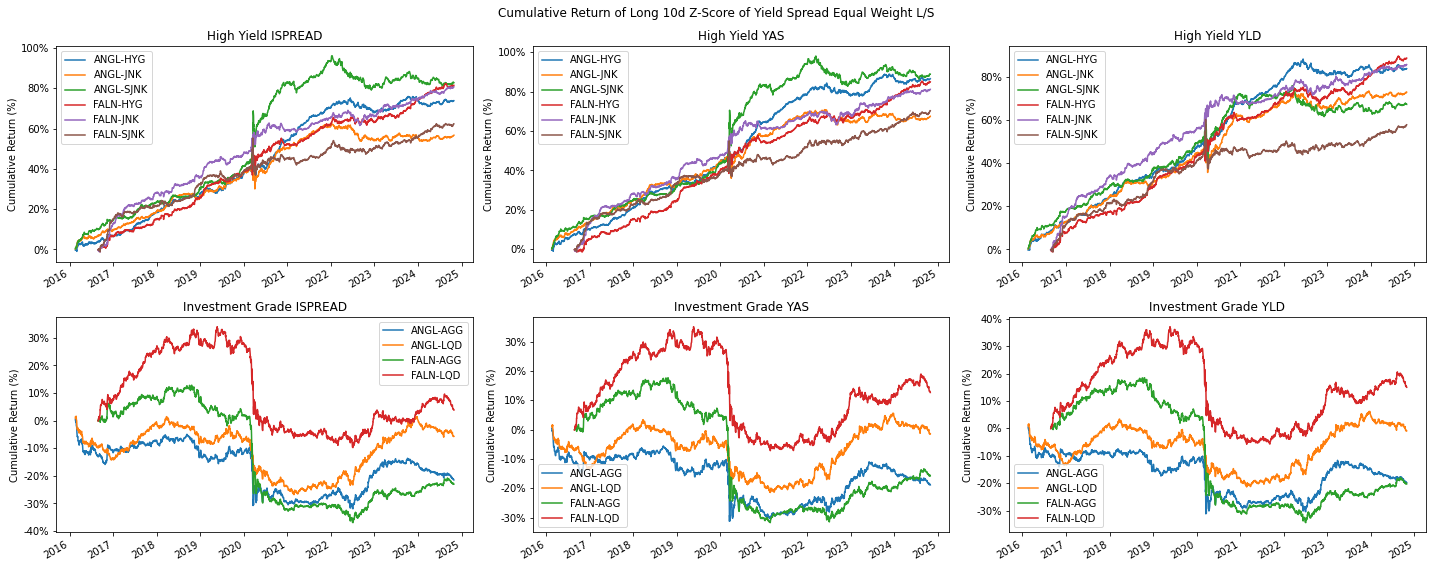

In [5]:
def plot_equal_rtn(df_equal_signal: pd.DataFrame) -> plt.Figure: 
    
    df_tmp = (df_equal_signal.assign(
        group_var = lambda x: x.bond_group + " " + x.variable))

    group_vars = df_tmp.group_var.drop_duplicates().sort_values().to_list()
    fig, axes  = plt.subplots(ncols = len(group_vars) // 2, nrows = len(group_vars) // 3, figsize = (20,8))

    for group_var, ax in zip(group_vars, axes.flatten()):

        (df_tmp.query(
            "group_var == @group_var").
            assign(ticker_spread = lambda x: x.ticker_spread.str.replace("_", "-")).
            rename(columns = {"ticker_spread": ""}).
            pivot(index = "date", columns = "", values = "signal_rtn").
            apply(lambda x: np.cumprod(1 + x) - 1).
            plot(
                title  = group_var,
                ax     = ax,
                xlabel = "",
                ylabel = "Cumulative Return (%)"))

        ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y * 100:.0f}%'))

    fig.suptitle("Cumulative Return of Long 10d Z-Score of Yield Spread Equal Weight L/S")
    plt.tight_layout()
    
plot_equal_rtn(df_equal_signal)

In [6]:
def get_equal_sharpe(df_equal_signal: pd.DataFrame) -> pd.DataFrame: 
    
    df_tmp = (df_equal_signal.assign(
        group_var = lambda x: x.bond_group + " " + x.variable))

    df_sharpe = (df_tmp[
        ["group_var", "ticker_spread", "signal_rtn"]].
        groupby(["group_var", "ticker_spread"]).
        agg(["mean", "std"])
        ["signal_rtn"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252)).
        reset_index())
    
    return df_sharpe

df_equal_sharpe = get_equal_sharpe(df_equal_signal)

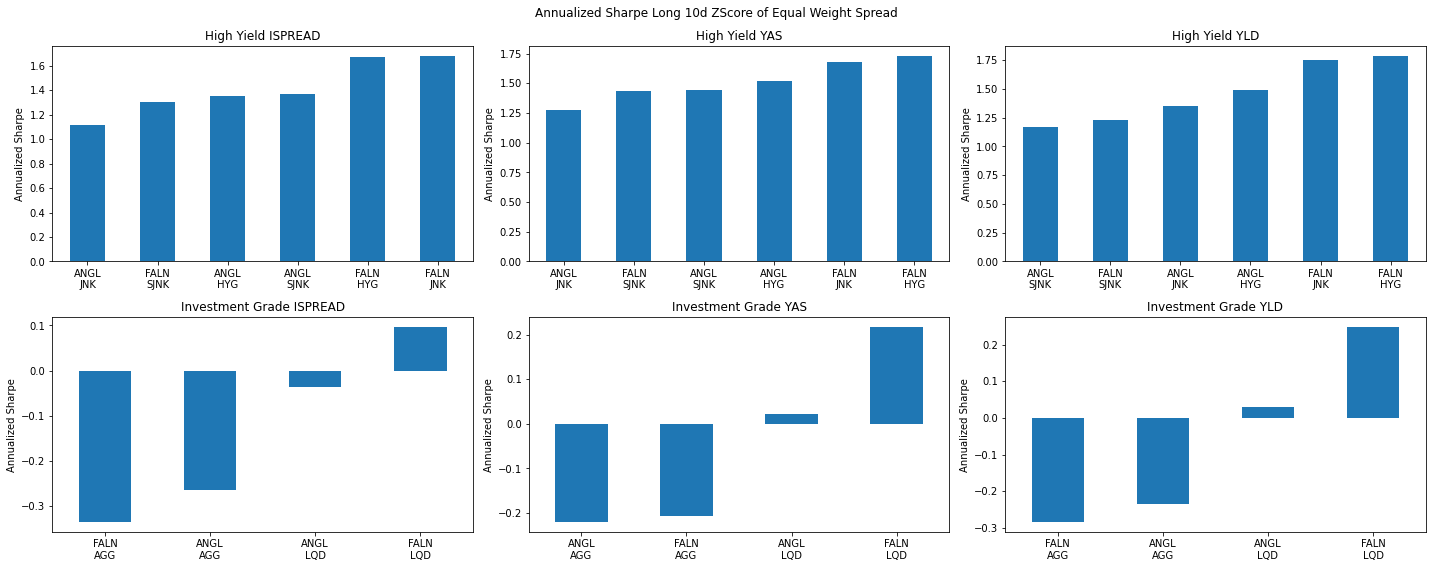

In [7]:
def plot_equal_sharpe(df_equal_sharpe: pd.DataFrame) -> pd.DataFrame: 
    
    group_vars = df_equal_sharpe.group_var.drop_duplicates().sort_values().to_list()
    fig, axes  = plt.subplots(ncols = len(group_vars) // 2, nrows = len(group_vars) // 3, figsize = (20,8))

    for group_var, ax in zip(group_vars, axes.flatten()): 

        (df_equal_sharpe.query(
            "group_var == @group_var").
            assign(ticker_spread = lambda x: x.ticker_spread.str.replace("_", "\n")).
            set_index("ticker_spread")
            [["sharpe"]].
            sort_values("sharpe").
            plot(
                ax     = ax,
                kind   = "bar",
                rot    = 0,
                xlabel = "",
                ylabel = "Annualized Sharpe",
                legend = False,
                title  = group_var))

    fig.suptitle("Annualized Sharpe Long 10d ZScore of Equal Weight Spread")
    plt.tight_layout()
    
plot_equal_sharpe(df_equal_sharpe)

In [8]:
def _get_ols(df: pd.DataFrame) -> pd.DataFrame:
    
    model = (sm.OLS(
        endog = df.spread,
        exog  = sm.add_constant(df.lag_zscore)).
        fit())
    
    df_val = (model.params.to_frame(
        name = "val").
        reset_index().
        rename(columns = {"index": "param"}))
    
    df_pval = (model.pvalues.to_frame(
        name = "pval").
        reset_index().
        rename(columns = {"index": "param"}))
    
    df_out = (df_val.merge(
        right = df_pval, how = "inner", on = ["param"]))
    
    return df_out

def get_ols_params(df_equal_signal: pd.DataFrame) -> pd.DataFrame: 

    df_params = (df_equal_signal.assign(
        group_var = lambda x: x.ticker_spread + " " + x.variable).
        groupby(["group_var", "bond_group"]).
        apply(_get_ols).
        reset_index().
        drop(columns = ["level_2"]))
    
    return df_params

df_params = get_ols_params(df_equal_signal)

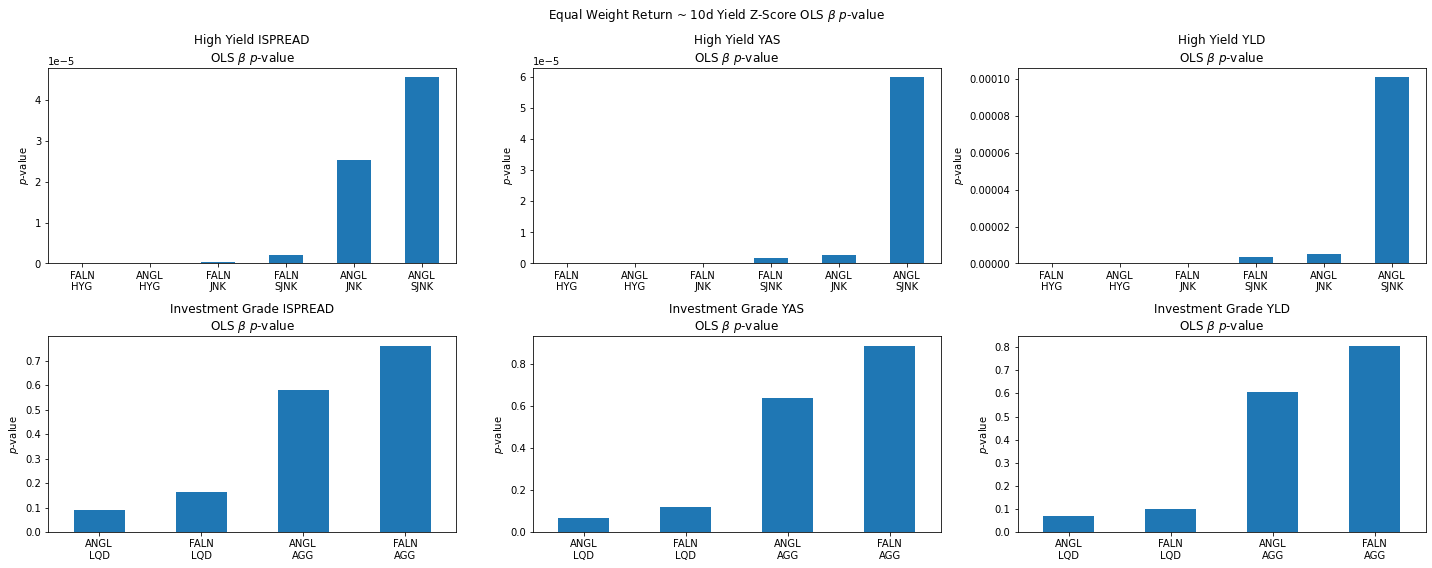

In [9]:
def plot_equal_weight_ols_pvalue(df_params: pd.DataFrame) -> plt.Figure: 
    
    df_tmp = (df_params.query(
        "param == 'lag_zscore'").
        assign(
            spread   = lambda x: x.group_var.str.split(" ").str[0],
            variable = lambda x: x.group_var.str.split(" ").str[1]).
        drop(columns = ["group_var"]).
        assign(group_var = lambda x: x.bond_group + " " + x.variable))

    group_vars = df_tmp.group_var.drop_duplicates().sort_values().to_list()
    fig, axes  = plt.subplots(ncols = len(group_vars) // 2, nrows = len(group_vars) // 3, figsize = (20,8))

    for group_var, ax in zip(group_vars, axes.flatten()):

        (df_tmp.query(
            "group_var == @group_var").
            assign(spread = lambda x: x.spread.str.replace("_", "\n")).
            set_index("spread")
            [["pval"]].
            sort_values("pval").
            plot(
                kind   = "bar",
                legend = False,
                ax     = ax,
                ylabel = r"$p$-value",
                rot    = 0,
                xlabel = "",
                title  = group_var + "\n" + r"OLS $\beta$ $p$-value"))

    fig.suptitle(r"Equal Weight Return ~ 10d Yield Z-Score OLS $\beta$ $p$-value")
    plt.tight_layout()
    
plot_equal_weight_ols_pvalue(df_params)

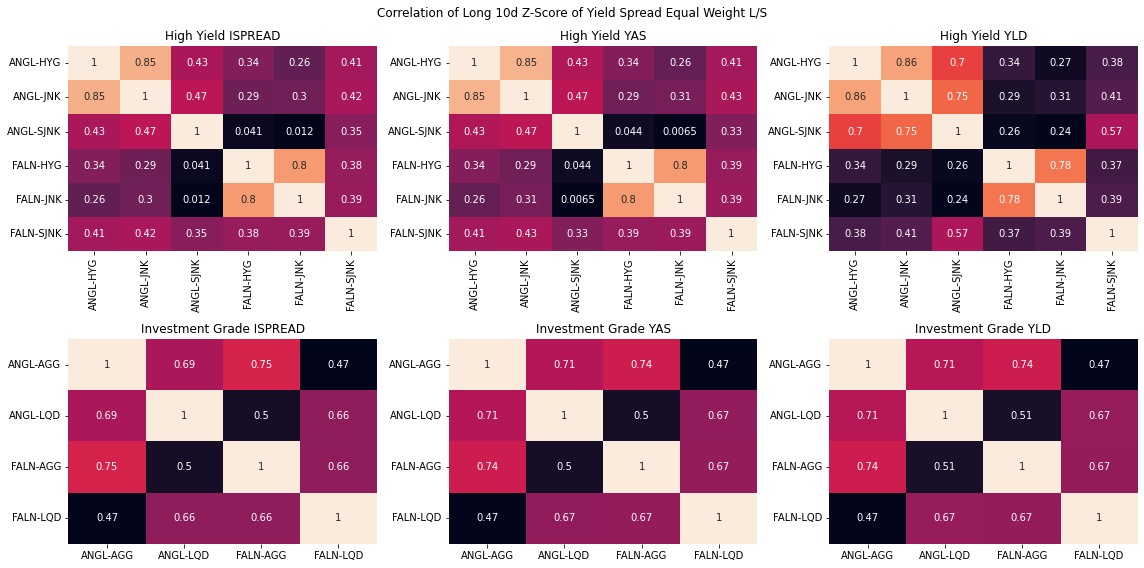

In [10]:
def plot_equal_signal_corr(df_equal_signal: pd.DataFrame) -> plt.Figure: 

    df_tmp = (df_equal_signal.assign(
        group_var = lambda x: x.bond_group + " " + x.variable))

    group_vars = df_tmp.group_var.drop_duplicates().sort_values().to_list()
    fig, axes  = plt.subplots(ncols = len(group_vars) // 2, nrows = len(group_vars) // 3, figsize = (16,8))

    for group_var, ax in zip(group_vars, axes.flatten()):

        df_plot = (df_tmp.query(
            "group_var == @group_var").
            assign(ticker_spread = lambda x: x.ticker_spread.str.replace("_", "-")).
            rename(columns = {"ticker_spread": ""}).
            pivot(index = "date", columns = "", values = "signal_rtn").
            corr())

        sns.heatmap(
            data  = df_plot, 
            ax    = ax, 
            annot = True,
            cbar  = False)

        ax.set_title(group_var)

    fig.suptitle("Correlation of Long 10d Z-Score of Yield Spread Equal Weight L/S")
    plt.tight_layout()
    
plot_equal_signal_corr(df_equal_signal)